In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras import initializers
from keras.layers import Dropout, Activation, Embedding, Convolution1D, MaxPooling1D, Input, Dense, Merge, \
                         BatchNormalization, Flatten, Reshape, Concatenate
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers

Using TensorFlow backend.


In [38]:

dj = pd.read_csv("Reliance1.csv")
news = pd.read_csv("Reliance.csv")

In [39]:

dj.isnull().sum()

Date         0
Open         6
High         6
Low          6
Close        6
Adj Close    6
Volume       6
dtype: int64

In [40]:
news.isnull().sum()

Date    0
News    0
dtype: int64

In [41]:
news.head()

,Date,News
0,03-01-11,Reliance Industries has commissioned its busin...
1,05-01-11,The current dip can be used as an opportunity ...
2,05-01-11,"Invest in Reliance Industries, says Devang Meh..."
3,05-01-11,"Reliance Industries a trading bet, says Sandee..."
4,07-01-11,"Pick Reliance Industries, says Vijay Bhambwani..."


In [42]:
print(dj.shape)
print(news.shape)

(1686, 7)
(4275, 2)


In [43]:
# Compare the number of unique dates. We want matching values.
print(len(set(dj.Date)))
print(len(set(news.Date)))

1686
1501


In [44]:
news=news.groupby('Date').sum()

In [45]:
news.head()

,News
Date,
01-01-16,The reforms carried out by the government are ...
01-01-17,Nine of the 10 most valued companies registere...
01-02-11,Reliance Industries touched an intraday high o...
01-02-12,Contrary to popular belief Reliance Industries...
01-02-13,"With over Rs 80,000 crore of investment in oil..."


In [46]:
news=news.reset_index()
news.head()

,Date,News
0,01-01-16,The reforms carried out by the government are ...
1,01-01-17,Nine of the 10 most valued companies registere...
2,01-02-11,Reliance Industries touched an intraday high o...
3,01-02-12,Contrary to popular belief Reliance Industries...
4,01-02-13,"With over Rs 80,000 crore of investment in oil..."


In [47]:
news['Date']=pd.to_datetime(news.Date)
news.head()

,Date,News
0,2016-01-01,The reforms carried out by the government are ...
1,2017-01-01,Nine of the 10 most valued companies registere...
2,2011-01-02,Reliance Industries touched an intraday high o...
3,2012-01-02,Contrary to popular belief Reliance Industries...
4,2013-01-02,"With over Rs 80,000 crore of investment in oil..."


In [48]:
news.sort_values(by='Date',ascending=True).head()

,Date,News
2,2011-01-02,Reliance Industries touched an intraday high o...
8,2011-01-03,Speaking at FICCI's 83rd Annual General Meetin...
11,2011-01-04,I won’t be too enthused on the stock beyond Rs...
17,2011-01-06,Faced with a gas crunch at its petrochemical p...
21,2011-01-07,It has been a series of positive days for the ...


In [49]:
news.shape

(1501, 2)

In [50]:
news=news[['Date','News']]

In [51]:
news.head()

,Date,News
0,2016-01-01,The reforms carried out by the government are ...
1,2017-01-01,Nine of the 10 most valued companies registere...
2,2011-01-02,Reliance Industries touched an intraday high o...
3,2012-01-02,Contrary to popular belief Reliance Industries...
4,2013-01-02,"With over Rs 80,000 crore of investment in oil..."


In [52]:
dj.shape

(1686, 7)

In [53]:

# Remove the extra dates that are in news
news = news[news.Date.isin(dj.Date)]

In [54]:
print(len(set(dj.Date)))
print(len(set(news.Date)))

1686
1163


In [54]:

# Calculate the difference in opening prices between the following and current day.
# The model will try to predict how much the Open value will change beased on the news.
#dj = dj.set_index('Date').diff(periods=1)
#dj['Date'] = dj.index
#dj = dj.reset_index(drop=True)
# Remove unneeded features
#dj = dj.drop(['High','Low','Close','Volume','Adj Close'], 1)

In [55]:

#dj.head()

,Open,Date
0,NaN,2011-01-03
1,NaN,2011-01-04
2,9.775024,2011-01-05
3,-7.725036,2011-01-06
4,-0.375000,2011-01-07


In [56]:
#dj = dj[dj.Open.notnull()]

In [57]:

# Check if there are any more null values.
#dj.isnull().sum()
dj=dj[['Date','Close','Adj Close']]
dj.head()

,Date,Close,Adj Close
0,2011-01-03,529.125000,459.736267
1,2011-01-04,538.275024,467.686401
2,2011-01-05,538.275024,467.686401
3,2011-01-06,542.000000,470.922852
4,2011-01-07,532.450012,462.625244


In [58]:
# Create a list of the opening prices and their corresponding daily headlines from the news
# Create a list of the opening prices and their corresponding daily headlines from the news
close = []
adj =[]
headlines = []
DateNew=[]
for row in dj.iterrows():
    daily_headlines = []
    daily_date=[]
    daily_close=[]
    daily_adj=[]
    date = row[1]['Date']
    close.append(row[1]['Close'])
    adj.append(row[1]['Adj Close'])
    
    for row_ in news[news.Date==date].iterrows():
        daily_headlines.append(row_[1]['News'])
        daily_date.append(row_[1]['Date'])
        #daily_close.append(row_[1]['Close'])
        #daily_adj.append(row_[1]['Adj Close'])
    # Track progress
    headlines.append(daily_headlines)
    DateNew.append(daily_date)
    #close.append(daily_close)
    #adj.append(daily_adj)
    if len(close) % 500 == 0:
        print(len(close))

500
1000
1500


In [ ]:
#df=df[df.astype(str)['Date'] != '[]']

In [60]:

# Compare lengths to ensure they are the same
print(len(close))
print(len(headlines))

1686
1686


In [61]:

# Compare the number of headlines for each day
print(max(len(i) for i in headlines))
print(min(len(i) for i in headlines))
#print(np.mean(len(i) for i in headlines))

1
0


In [62]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [63]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [64]:
# Clean the headlines
clean_headlines = []

for daily_headlines in headlines:
    clean_daily_headlines = []
    for headline in daily_headlines:
        clean_daily_headlines.append(clean_text(headline))
    clean_headlines.append(clean_daily_headlines)

In [65]:

# Take a look at some headlines to ensure everything was cleaned well
clean_headlines[1]

['won’t enthused stock beyond rs 1050 one see q4 results till maybe next one month keep level rs 1050 says sp tulsian sptulsian com']

In [66]:
# Find the number of times each word was used and the size of the vocabulary
word_counts = {}

for date in clean_headlines:
    for headline in date:
        for word in headline.split():
            if word not in word_counts:
                word_counts[word] = 1
            else:
                word_counts[word] += 1
            
print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 7343


In [67]:
# Load GloVe's embeddings
embeddings_index = {}
with open('glove.840B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))

Word embeddings: 94


In [68]:
# Find the number of words that are missing from GloVe, and are used more than our threshold.
missing_words = 0
threshold = 10

for word, count in word_counts.items():
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100
            
print("Number of words missing from GloVe:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))

Number of words missing from GloVe: 1032
Percent of words that are missing from vocabulary: 14.05%


In [69]:
 # Limit the vocab that we will use to words that appear ≥ threshold or are in GloVe

#dictionary to convert words to integers
vocab_to_int = {} 

value = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        vocab_to_int[word] = value
        value += 1

# Special tokens that will be added to our vocab
codes = ["<UNK>","<PAD>"]   

# Add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

print("Total Number of Unique Words:", len(word_counts))
print("Number of Words we will use:", len(vocab_to_int))
print("Percent of Words we will use: {}%".format(usage_ratio))

Total Number of Unique Words: 7343
Number of Words we will use: 1142
Percent of Words we will use: 15.55%


In [70]:
# Need to use 300 for embedding dimensions to match GloVe's vectors.
embedding_dim = 300

nb_words = len(vocab_to_int)
# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim))
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in GloVe, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(vocab_to_int)
print(len(word_embedding_matrix))

1142


In [71]:
# Change the text from words to integers
# If word is not in vocab, replace it with <UNK> (unknown)
word_count = 0
unk_count = 0

int_headlines = []

for date in clean_headlines:
    int_daily_headlines = []
    for headline in date:
        int_headline = []
        for word in headline.split():
            word_count += 1
            if word in vocab_to_int:
                int_headline.append(vocab_to_int[word])
            else:
                int_headline.append(vocab_to_int["<UNK>"])
                unk_count += 1
        int_daily_headlines.append(int_headline)
    int_headlines.append(int_daily_headlines)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in headlines:", word_count)
print("Total number of UNKs in headlines:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

Total number of words in headlines: 66861
Total number of UNKs in headlines: 14158
Percent of words that are UNK: 21.18%


In [72]:
# Find the length of headlines
lengths = []
for date in int_headlines:
    for headline in date:
        lengths.append(len(headline))

# Create a dataframe so that the values can be inspected
lengths = pd.DataFrame(lengths, columns=['counts'])

In [73]:
lengths.describe()

,counts
count,1163.000000
mean,57.490112
std,54.353251
min,4.000000
25%,23.000000
50%,41.000000
75%,72.500000
max,449.000000


In [74]:
# Limit the length of a day's news to 200 words, and the length of any headline to 16 words.
# These values are chosen to not have an excessively long training time and 
# balance the number of headlines used and the number of words from each headline.
max_headline_length = 16
max_daily_length = 200
pad_headlines = []

for date in int_headlines:
    pad_daily_headlines = []
    for headline in date:
        # Add headline if it is less than max length
        if len(headline) <= max_headline_length:
            for word in headline:
                pad_daily_headlines.append(word)
        # Limit headline if it is more than max length  
        else:
            headline = headline[:max_headline_length]
            for word in headline:
                pad_daily_headlines.append(word)
    
    # Pad daily_headlines if they are less than max length
    if len(pad_daily_headlines) < max_daily_length:
        for i in range(max_daily_length-len(pad_daily_headlines)):
            pad = vocab_to_int["<PAD>"]
            pad_daily_headlines.append(pad)
    # Limit daily_headlines if they are more than max length
    else:
        pad_daily_headlines = pad_daily_headlines[:max_daily_length]
    pad_headlines.append(pad_daily_headlines)

In [89]:
df = pd.DataFrame({'Date':DateNew,'Close':close,'Adj_Close':adj,'News':headlines})

In [90]:
df.head()

,Adj_Close,Close,Date,News
0,459.736267,529.125000,[2011-01-03 00:00:00],[Speaking at FICCI's 83rd Annual General Meeti...
1,467.686401,538.275024,[2011-01-04 00:00:00],[I won’t be too enthused on the stock beyond R...
2,467.686401,538.275024,[],[]
3,470.922852,542.000000,[2011-01-06 00:00:00],[Faced with a gas crunch at its petrochemical ...
4,462.625244,532.450012,[2011-01-07 00:00:00],[It has been a series of positive days for the...


In [77]:
# Remove top row since it has a null value.
df = df[df.Date.notnull()]
df=df[df.Close.notnull()]
df=df[df.Adj_Close.notnull()]

In [78]:
df.isnull().sum()

Adj_Close    0
Close        0
Date         0
News         0
dtype: int64

In [91]:
df=df[df.astype(str)['Date'] != '[]']

In [92]:
df.head()

,Adj_Close,Close,Date,News
0,459.736267,529.125000,[2011-01-03 00:00:00],[Speaking at FICCI's 83rd Annual General Meeti...
1,467.686401,538.275024,[2011-01-04 00:00:00],[I won’t be too enthused on the stock beyond R...
3,470.922852,542.000000,[2011-01-06 00:00:00],[Faced with a gas crunch at its petrochemical ...
4,462.625244,532.450012,[2011-01-07 00:00:00],[It has been a series of positive days for the...
8,441.055725,507.625000,[2011-01-13 00:00:00],"[Buy Reliance Industries on dips, says Ambaree..."


In [93]:
df=df[['Date','Close','Adj_Close','News']]

In [80]:
df = df.reset_index(drop=True)
df.head()

,Date,Close,Adj_Close,News
0,[2011-01-03 00:00:00],529.125000,459.736267,[Speaking at FICCI's 83rd Annual General Meeti...
1,[2011-01-04 00:00:00],538.275024,467.686401,[I won’t be too enthused on the stock beyond R...
2,[],538.275024,467.686401,[]
3,[2011-01-06 00:00:00],542.000000,470.922852,[Faced with a gas crunch at its petrochemical ...
4,[2011-01-07 00:00:00],532.450012,462.625244,[It has been a series of positive days for the...


In [81]:
df.News[4]

["It has been a series of positive days for the markets, until the closing on the last day of the week. However, it is not the time to reach the panic button yet, says CNBC-TV18’s Udayan Mukherjee.The Central Bureau of Investigation (CBI) searched the house of a former upstream regulator on Friday, the first investigative action after the CAG said in a report there may have been inflated costs for some of Reliance Industries' exploration activities.Reliance Industries touched an intraday high of Rs 906 and an intraday low of Rs 875.60. At 12:37 hrs the share was quoting at Rs 876.90, down Rs 20.70, or 2.31%."]

In [94]:
df['News']=df['News'].apply(lambda x: ', '.join(x))

In [95]:
df['Date']=pd.to_datetime(df.Date.apply(lambda x: x[0]))

In [96]:
df.head()

,Date,Close,Adj_Close,News
0,2011-01-03,529.125000,459.736267,Speaking at FICCI's 83rd Annual General Meetin...
1,2011-01-04,538.275024,467.686401,I won’t be too enthused on the stock beyond Rs...
3,2011-01-06,542.000000,470.922852,Faced with a gas crunch at its petrochemical p...
4,2011-01-07,532.450012,462.625244,It has been a series of positive days for the ...
8,2011-01-13,507.625000,441.055725,"Buy Reliance Industries on dips, says Ambarees..."


In [97]:
df3=df.set_index('Date')

In [98]:
df3.head()

,Close,Adj_Close,News
Date,,,
2011-01-03,529.125000,459.736267,Speaking at FICCI's 83rd Annual General Meetin...
2011-01-04,538.275024,467.686401,I won’t be too enthused on the stock beyond Rs...
2011-01-06,542.000000,470.922852,Faced with a gas crunch at its petrochemical p...
2011-01-07,532.450012,462.625244,It has been a series of positive days for the ...
2011-01-13,507.625000,441.055725,"Buy Reliance Industries on dips, says Ambarees..."


In [102]:
# Saving the data as pickle file
df3.to_pickle('Upickled_ten_year_filtered_data.pkl')  

In [103]:
# Save pandas frame in csv form
df3.to_csv('sample_interpolated_df_10_years_filtered_data.csv',
                       sep='\t', encoding='utf-8')

In [104]:
# Reading the data as pickle file
dataframe_read = pd.read_pickle('Upickled_ten_year_filtered_data.pkl')

In [78]:
# Normalize opening prices (target values)
max_price = max(price)
min_price = min(price)
mean_price = np.mean(price)
def normalize(price):
    return ((price-min_price)/(max_price-min_price))

In [79]:
norm_price = []
for p in price:
    norm_price.append(normalize(p))

In [80]:
# Check that normalization worked well
print(min(norm_price))
print(max(norm_price))
print(np.mean(norm_price))

0.0
1.0
0.507162837416


In [81]:
# Split data into training and testing sets.
# Validating data will be created during training.
x_train, x_test, y_train, y_test = train_test_split(pad_headlines, norm_price, test_size = 0.15, random_state = 2)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [82]:
# Check the lengths
print(len(x_train))
print(len(x_test))

1416
250


In [83]:
filter_length1 = 3
filter_length2 = 5
dropout = 0.5
learning_rate = 0.001
weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=2)
nb_filter = 16
rnn_output_size = 128
hidden_dims = 128
wider = True
deeper = True

if wider == True:
    nb_filter *= 2
    rnn_output_size *= 2
    hidden_dims *= 2


def build_model():
    
    model1 = Sequential()
    
    model1.add(Embedding(nb_words, 
                         embedding_dim,
                         weights=[word_embedding_matrix], 
                         input_length=max_daily_length))
    model1.add(Dropout(dropout))
    
    model1.add(Convolution1D(filters = nb_filter, 
                             kernel_size = filter_length1, 
                             padding = 'same',
                            activation = 'relu'))
    model1.add(Dropout(dropout))
    
    if deeper == True:
        model1.add(Convolution1D(filters = nb_filter, 
                                 kernel_size = filter_length1, 
                                 padding = 'same',
                                activation = 'relu'))
        model1.add(Dropout(dropout))
    
    model1.add(LSTM(rnn_output_size, 
                   activation=None,
                   kernel_initializer=weights,
                   dropout = dropout))
    
    ####

    model2 = Sequential()
    
    model2.add(Embedding(nb_words, 
                         embedding_dim,
                         weights=[word_embedding_matrix], 
                         input_length=max_daily_length))
    model2.add(Dropout(dropout))
    
    
    model2.add(Convolution1D(filters = nb_filter, 
                             kernel_size = filter_length2, 
                             padding = 'same',
                             activation = 'relu'))
    model2.add(Dropout(dropout))
    
    if deeper == True:
        model2.add(Convolution1D(filters = nb_filter, 
                                 kernel_size = filter_length2, 
                                 padding = 'same',
                                 activation = 'relu'))
        model2.add(Dropout(dropout))
    
    model2.add(LSTM(rnn_output_size, 
                    activation=None,
                    kernel_initializer=weights,
                    dropout = dropout))
    
    ####

    model = Sequential()

    model.add(Merge([model1, model2], mode='concat'))
    
    model.add(Dense(hidden_dims, kernel_initializer=weights))
    model.add(Dropout(dropout))
    
    if deeper == True:
        model.add(Dense(hidden_dims//2, kernel_initializer=weights))
        model.add(Dropout(dropout))

    model.add(Dense(1, 
                    kernel_initializer = weights,
                    name='output'))

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(lr=learning_rate,clipvalue=1.0))
    return model

In [84]:
# Use grid search to help find a better model
for deeper in [False]:
    for wider in [True,False]:
        for learning_rate in [0.001]:
            for dropout in [0.3, 0.5]:
                model = build_model()
                print()
                print("Current model: Deeper={}, Wider={}, LR={}, Dropout={}".format(
                    deeper,wider,learning_rate,dropout))
                print()
                save_best_weights = 'question_pairs_weights_deeper={}_wider={}_lr={}_dropout={}.h5'.format(
                    deeper,wider,learning_rate,dropout)

                callbacks = [ModelCheckpoint(save_best_weights, monitor='val_loss', save_best_only=True),
                             EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto'),
                             ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3)]

                history = model.fit([x_train,x_train],
                                    y_train,
                                    batch_size=128,
                                    epochs=100,
                                    validation_split=0.15,
                                    verbose=True,
                                    shuffle=True,
                                    callbacks = callbacks)



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.



Current model: Deeper=False, Wider=True, LR=0.001, Dropout=0.3

Train on 1203 samples, validate on 213 samples
Epoch 1/100
1203/1203 [==============================] - 94s - loss: nan - val_loss: nan

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:407: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:499: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:859: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.epsilon)



Epoch 2/100
1203/1203 [==============================] - 102s - loss: nan - val_loss: nan
Epoch 3/100
1203/1203 [==============================] - 114s - loss: nan - val_loss: nan
Epoch 4/100
1152/1203 [===========================>..] - ETA: 4s - loss: nan 
Epoch 00003: reducing learning rate to 0.00020000000949949026.
1203/1203 [==============================] - 117s - loss: nan - val_loss: nan
Epoch 5/100
1203/1203 [==============================] - 117s - loss: nan - val_loss: nan
Epoch 6/100
1203/1203 [==============================] - 125s - loss: nan - val_loss: nan
Epoch 00005: early stopping

Current model: Deeper=False, Wider=True, LR=0.001, Dropout=0.5

Train on 1203 samples, validate on 213 samples
Epoch 1/100
1203/1203 [==============================] - 125s - loss: nan - val_loss: nan
Epoch 2/100
1203/1203 [==============================] - 136s - loss: nan - val_loss: nan
Epoch 3/100
1203/1203 [==============================] - 137s - loss: nan - val_loss: nan
Epoch 4/10

In [87]:
# Make predictions with the best weights
deeper=False
wider=False
dropout=0.3
learning_Rate = 0.001
# Need to rebuild model in case it is different from the model that was trained most recently.
model = build_model()

model.load_weights('./question_pairs_weights_deeper={}_wider={}_lr={}_dropout={}.h5'.format(
                    deeper,wider,learning_rate,dropout))
predictions = model.predict([x_test,x_test], verbose = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


250/250 [==============================] - 8s     


In [88]:
# Compare testing loss to training and validating loss
mse(y_test, predictions)

0.0052040026417438075

In [89]:
def unnormalize(price):
    '''Revert values to their unnormalized amounts'''
    price = price*(max_price-min_price)+min_price
    return(price)

In [90]:
unnorm_predictions = []
for pred in predictions:
    unnorm_predictions.append(unnormalize(pred))
    
unnorm_y_test = []
for y in y_test:
    unnorm_y_test.append(unnormalize(y))

In [91]:
# Calculate the median absolute error for the predictions
mae(unnorm_y_test, unnorm_predictions)

7.0750120000000152

In [92]:
print("Summary of actual opening price changes")
print(pd.DataFrame(unnorm_y_test, columns=[""]).describe())
print()
print("Summary of predicted opening price changes")
print(pd.DataFrame(unnorm_predictions, columns=[""]).describe())

Summary of actual opening price changes
                 
count  250.000000
mean     0.147098
std     10.685219
min    -31.149994
25%     -6.731239
50%      0.575027
75%      7.281265
max     36.649994

Summary of predicted opening price changes
                 
count  250.000000
mean    -2.084176
std      0.000003
min     -2.084183
25%     -2.084175
50%     -2.084175
75%     -2.084175
max     -2.084167


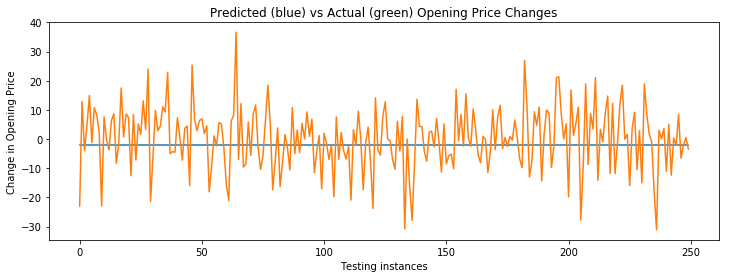

In [93]:
# Plot the predicted (blue) and actual (green) values
plt.figure(figsize=(12,4))
plt.plot(unnorm_predictions)
plt.plot(unnorm_y_test)
plt.title("Predicted (blue) vs Actual (green) Opening Price Changes")
plt.xlabel("Testing instances")
plt.ylabel("Change in Opening Price")
plt.show()

In [94]:
# Create lists to measure if opening price increased or decreased
direction_pred = []
for pred in unnorm_predictions:
    if pred >= 0:
        direction_pred.append(1)
    else:
        direction_pred.append(0)
direction_test = []
for value in unnorm_y_test:
    if value >= 0:
        direction_test.append(1)
    else:
        direction_test.append(0)

In [95]:
# Calculate if the predicted direction matched the actual direction
direction = acc(direction_test, direction_pred)
direction = round(direction,4)*100
print("Predicted values matched the actual direction {}% of the time.".format(direction))

Predicted values matched the actual direction 46.0% of the time.


In [ ]:
#Make Your Own Predictions


In [96]:
def news_to_int(news):
    '''Convert your created news into integers'''
    ints = []
    for word in news.split():
        if word in vocab_to_int:
            ints.append(vocab_to_int[word])
        else:
            ints.append(vocab_to_int['<UNK>'])
    return ints

In [97]:
def padding_news(news):
    '''Adjusts the length of your created news to fit the model's input values.'''
    padded_news = news
    if len(padded_news) < max_daily_length:
        for i in range(max_daily_length-len(padded_news)):
            padded_news.append(vocab_to_int["<PAD>"])
    elif len(padded_news) > max_daily_length:
        padded_news = padded_news[:max_daily_length]
    return padded_news

In [99]:
# Default news that you can us
create_news = "It has been a series of positive days for the markets, until the closing on the last\
day of the week. However, it is not the time to reach the panic button yet, says CNBC-TV18’s Udayan \
Mukherjee.The Central Bureau of Investigation (CBI) searched the house of a former upstream regulato\
on Friday, the first investigative action after the CAG said in a report there may have been inflated\
costs for some of Reliance Industries' exploration activities.Reliance Industries touched an intraday\
high of Rs 906 and an intraday low of Rs 875.60. At 12:37 hrs the share was quoting at Rs 876.90, down \
    Rs 20.70, or 2.31%."
           

clean_news = clean_text(create_news)

int_news = news_to_int(clean_news)

pad_news = padding_news(int_news)

pad_news = np.array(pad_news).reshape((1,-1))

pred = model.predict([pad_news,pad_news])

price_change = unnormalize(pred)
print("The RIL should open: {} from the previous open.".format(np.round(price_change[0][0],2)))

The RIL should open: 647.260009765625 from the previous open.
